# shp

> Spatially Homogenious Pixels Identification

In [ ]:
#| default_exp cli/shp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from matplotlib import pyplot as plt
import zarr
import colorcet
import moraine.cli as mc
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
from itertools import product
import math
import logging

import zarr
import numcodecs
import numpy as np

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, progress
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster

import moraine as mr
from moraine.cli.logging import mc_logger

In [ ]:
#| export
@mc_logger
def shp_test(rslc:str, # input: rslc stack
             pvalue:str, # output: the p value of the test
             az_half_win:int, # azimuth half window size
             r_half_win:int, # range half window size
             method:str=None, # SHP identification method,optional. Default: ks
             chunks:tuple[int,int]=None, # chunk size, optional. Default: the chunk size in rslc
            ):
    '''SHP identification through hypothetic test.'''
    rslc_path = rslc
    pvalue_path = pvalue

    logger = logging.getLogger(__name__)
    if not method: method = 'ks'
    logger.info(f'hypothetic test method: {method}')
    if method != 'ks':
        logger.warning('Currently only KS test is implented. Switching to it.')
        method = 'ks'

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path,rslc_zarr)

    assert rslc_zarr.ndim == 3, " rslcs dimentation is not 3."
    
    if chunks is None: chunks = rslc_zarr.chunks[:2]
    chunks=(*chunks,*rslc_zarr.shape[2:])

    logger.info('starting dask CUDA local cluster.')
    with LocalCUDACluster() as cluster, Client(cluster) as client:
        logger.info('dask local CUDA cluster started.')

        cpu_rslc = da.from_zarr(rslc_path,chunks=chunks); logger.darr_info('rslc',cpu_rslc)

        az_win = 2*az_half_win+1
        logger.info(f'azimuth half window size: {az_half_win}; azimuth window size: {az_win}')
        r_win = 2*r_half_win+1
        logger.info(f'range half window size: {r_half_win}; range window size: {r_win}')

        depth = {0:az_half_win, 1:r_half_win, 2:0}; boundary = {0:'none',1:'none',2:'none'}
        cpu_rslc_overlap = da.overlap.overlap(cpu_rslc,depth=depth, boundary=boundary)
        logger.info('setting shared boundaries between rlsc chunks.')
        logger.darr_info('rslc with overlap', cpu_rslc_overlap)

        rslc_overlap = cpu_rslc_overlap.map_blocks(cp.asarray)
        rmli_overlap = da.abs(rslc_overlap)**2
        logger.darr_info('rmli with overlap', rmli_overlap)

        sorted_rmli_overlap = rmli_overlap.map_blocks(cp.sort,axis=-1)

        delayed_ks_test = delayed(mr.ks_test,pure=True,nout=2)
        rmli_delayed = sorted_rmli_overlap.to_delayed()
        p_delayed = np.empty_like(rmli_delayed,dtype=object)
        dist_delayed = np.empty_like(rmli_delayed,dtype=object)

        logger.info('applying test on sorted rmli stack.')
        with np.nditer(p_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as p_it:
            for p_block in p_it:
                idx = p_it.multi_index
                dist_delayed[idx],p_delayed[idx] = delayed_ks_test(rmli_delayed[idx],az_half_win=az_half_win,r_half_win=r_half_win)

                chunk_shape = (*sorted_rmli_overlap.blocks[idx].shape[:-1],az_win,r_win)
                dtype = sorted_rmli_overlap.dtype
                # dist_delayed[idx] = da.from_delayed(dist_delayed[idx],shape=chunk_shape,meta=cp.array((),dtype=dtype))
                p_delayed[idx] = da.from_delayed(p_delayed[idx],shape=chunk_shape,meta=cp.array((),dtype=dtype))

        p = da.block(p_delayed.reshape(*p_delayed.shape,1).tolist())
        # dist = da.block(dist_delayed.reshape(*dist_delayed.shape,1).tolist())
        logger.info('p value generated')
        logger.darr_info('p value', p)

        depth = {0:az_half_win, 1:r_half_win, 2:0, 3:0}; boundary = {0:'none',1:'none',2:'none',3:'none'}
        # dist = da.overlap.trim_overlap(dist,depth=depth,boundary=boundary)
        p = da.overlap.trim_overlap(p,depth=depth,boundary=boundary)
        p = p.rechunk((*p.chunks[:2],1,1))
        logger.info('trim shared boundaries between p value chunks and rechunk')
        logger.darr_info('p value', p)

        cpu_p = p.map_blocks(cp.asnumpy)
        _p = da.to_zarr(cpu_p,pvalue_path,compute=False,overwrite=True,compressor=numcodecs.LZ4(5))
        # p_zarr = kvikio.zarr.open_cupy_array(pvalue_path,'w',shape=p.shape, chunks=p.chunksize, dtype=p.dtype,compressor=None)
        # _p = da.store(p,p_zarr,compute=False,lock=False)
        logger.info('saving p value.')

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_p)
        progress(futures,notebook=False)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

This function is a wrapper of functions in `decorrelation.shp` that provides file interface. Please refer it for the usage. It utilizes dask for parallel and distributed computation. Compared with the functions in `decorrelation.shp`, this function splits the dataset into several chunks and the computation in these chunks can run in parallel on multi-GPUs.

The `r_chunk_size` and `az_chunk_size` is used to determine how many pixels in range and azimuth in one chunk. The chunk size of the output pvalue is also setted according to them.

In [ ]:
# rslc = '../../data/rslc.zarr'
rslc = './raw/rslc.zarr'
pvalue = './shp/pvalue.zarr'

In [ ]:
logger = mc.get_logger()

In [ ]:
%%time
if is_cuda_available():
    shp_test(rslc,pvalue,az_half_win=5,r_half_win=5, method=None,chunks=(1000,1000))

2024-04-30 22:38:22 - log_args - INFO - running function: shp_test
2024-04-30 22:38:22 - log_args - INFO - fetching args:
2024-04-30 22:38:22 - log_args - INFO - rslc = './raw/rslc.zarr'
2024-04-30 22:38:22 - log_args - INFO - pvalue = './shp/pvalue.zarr'
2024-04-30 22:38:22 - log_args - INFO - az_half_win = 5
2024-04-30 22:38:22 - log_args - INFO - r_half_win = 5
2024-04-30 22:38:22 - log_args - INFO - method = None
2024-04-30 22:38:22 - log_args - INFO - chunks = (1000, 1000)
2024-04-30 22:38:22 - log_args - INFO - fetching args done.
2024-04-30 22:38:22 - shp_test - INFO - hypothetic test method: ks
2024-04-30 22:38:22 - zarr_info - INFO - ./raw/rslc.zarr zarray shape: (2500, 1834, 17)
2024-04-30 22:38:22 - zarr_info - INFO - ./raw/rslc.zarr zarray chunks: (1000, 1000, 1)
2024-04-30 22:38:22 - zarr_info - INFO - ./raw/rslc.zarr zarray dtype: complex64
2024-04-30 22:38:22 - shp_test - INFO - starting dask CUDA local cluster.
2024-04-30 22:38:24 - shp_test - INFO - dask local CUDA clu

This function can also be called from command line directly:

In [ ]:
#| export
@mc_logger
def select_shp(pvalue:str, # input: pvalue of hypothetic test
               is_shp:str, # output: bool array indicating the SHPs
               shp_num:str, # output: integer array indicating number of SHPs
               p_max:float=0.05, # threshold of p value to select SHP,optional. Default: 0.05
               chunks:tuple[int,int]=None, # chunk size, optional. Default: the chunk size in rslc
              ):
    '''
    Select SHP based on pvalue of SHP test.
    '''
    is_shp_path = is_shp
    shp_num_path = shp_num
    logger = logging.getLogger(__name__)

    p_zarr = zarr.open(pvalue,mode='r'); logger.zarr_info(pvalue, p_zarr)
    assert p_zarr.ndim == 4, " pvalue dimentation is not 4."

    if chunks is None: chunks = p_zarr.chunks[:2]
    chunks=(*chunks,*p_zarr.shape[2:])

    logger.info('starting dask cuda cluster.')
    with LocalCUDACluster() as cluster, Client(cluster) as client:
        logger.info('dask cluster started.')

        p_cpu = da.from_zarr(pvalue,chunks=chunks)
        logger.darr_info('pvalue', p_cpu)
        p = da.map_blocks(cp.asarray,p_cpu[:])

        is_shp = (p < p_max) & (p >= 0)
        logger.info('selecting SHPs based on pvalue threshold: '+str(p_max))
        logger.darr_info('is_shp', is_shp)

        logger.info('calculate shp_num.')
        shp_num = da.count_nonzero(is_shp,axis=(-2,-1)).astype(cp.int32)
        logger.darr_info('shp_num',shp_num)

        is_shp_cpu = da.map_blocks(cp.asnumpy,is_shp)
        shp_num_cpu = da.map_blocks(cp.asnumpy,shp_num)
        logger.info('rechunk is_shp')
        is_shp_cpu = is_shp_cpu.rechunk((*is_shp_cpu.chunksize[0:2],1,1)); logger.darr_info('is_shp', is_shp_cpu)
        _is_shp = is_shp_cpu.to_zarr(is_shp_path,overwrite=True,compute=False)
        logger.info('saving is_shp.')
        _shp_num = shp_num_cpu.to_zarr(shp_num_path,overwrite=True,compute=False)
        logger.info('saving shp_num.')
        logger.info('computing graph setted. doing all the computing.')

        futures = client.persist([_is_shp,_shp_num])
        progress(futures,notebook=False)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pvalue = './shp/pvalue.zarr'
is_shp = './shp/is_shp.zarr'
shp_num = './shp/num.zarr'
p_max = 0.05

In [ ]:
%%time
if is_cuda_available():
    select_shp(pvalue,is_shp,shp_num,p_max=p_max)

2024-04-30 22:38:35 - log_args - INFO - running function: select_shp
2024-04-30 22:38:35 - log_args - INFO - fetching args:
2024-04-30 22:38:35 - log_args - INFO - pvalue = './shp/pvalue.zarr'
2024-04-30 22:38:35 - log_args - INFO - is_shp = './shp/is_shp.zarr'
2024-04-30 22:38:35 - log_args - INFO - shp_num = './shp/num.zarr'
2024-04-30 22:38:35 - log_args - INFO - p_max = 0.05
2024-04-30 22:38:35 - log_args - INFO - chunks = None
2024-04-30 22:38:35 - log_args - INFO - fetching args done.
2024-04-30 22:38:35 - zarr_info - INFO - ./shp/pvalue.zarr zarray shape: (2500, 1834, 11, 11)
2024-04-30 22:38:35 - zarr_info - INFO - ./shp/pvalue.zarr zarray chunks: (1000, 1000, 1, 1)
2024-04-30 22:38:35 - zarr_info - INFO - ./shp/pvalue.zarr zarray dtype: float32
2024-04-30 22:38:35 - select_shp - INFO - starting dask cuda cluster.
2024-04-30 22:38:37 - select_shp - INFO - dask cluster started.
2024-04-30 22:38:37 - darr_info - INFO - pvalue dask array shape: (2500, 1834, 11, 11)
2024-04-30 22:3

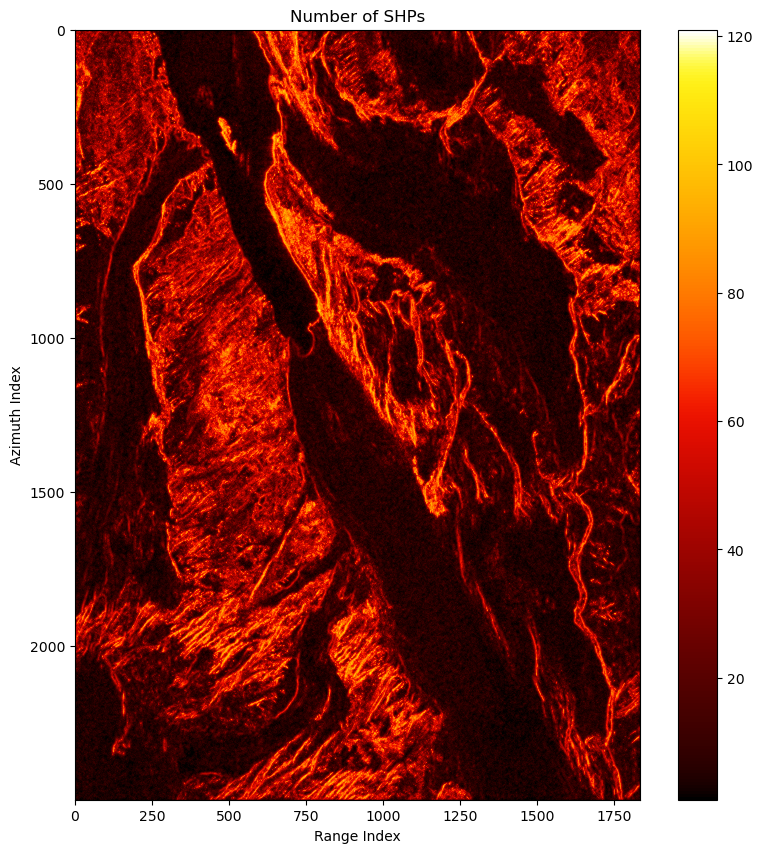

In [ ]:
shp_num_zarr = zarr.open(shp_num,'r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(shp_num_zarr[:],cmap=colorcet.cm.fire)
ax.set(title='Number of SHPs',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

Then we can select DS candidates based on number of SHPs and slice is_shp only on DS candidates.

In [ ]:
ds_can_gix = './shp/ds_can_gix.zarr'
is_ds_can= './shp/is_ds_can.zarr'
ds_can_is_shp = './shp/ds_can_is_shp.zarr'

In [ ]:
mc.pc_logic_ras(shp_num,ds_can_gix,'ras>=50')

2024-04-30 22:38:52 - log_args - INFO - running function: pc_logic_ras
2024-04-30 22:38:52 - log_args - INFO - fetching args:
2024-04-30 22:38:52 - log_args - INFO - ras = './shp/num.zarr'
2024-04-30 22:38:52 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2024-04-30 22:38:52 - log_args - INFO - operation = 'ras>=50'
2024-04-30 22:38:52 - log_args - INFO - chunks = 100000
2024-04-30 22:38:52 - log_args - INFO - fetching args done.
2024-04-30 22:38:52 - zarr_info - INFO - ./shp/num.zarr zarray shape: (2500, 1834)
2024-04-30 22:38:52 - zarr_info - INFO - ./shp/num.zarr zarray chunks: (1000, 1000)
2024-04-30 22:38:52 - zarr_info - INFO - ./shp/num.zarr zarray dtype: int32
2024-04-30 22:38:52 - pc_logic_ras - INFO - loading ras into memory.
2024-04-30 22:38:52 - pc_logic_ras - INFO - select pc based on operation: ras>=50
2024-04-30 22:38:52 - pc_logic_ras - INFO - number of selected pixels: 740397.
2024-04-30 22:38:52 - pc_logic_ras - INFO - writing gix.
2024-04-30 22:38:52 - pc_logic_ra

In [ ]:
mc.ras2pc(ds_can_gix, is_shp, ds_can_is_shp)
mc.gix2bool(ds_can_gix, is_ds_can, shape= shp_num_zarr.shape)

2024-04-30 22:38:52 - log_args - INFO - running function: ras2pc
2024-04-30 22:38:52 - log_args - INFO - fetching args:
2024-04-30 22:38:52 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2024-04-30 22:38:52 - log_args - INFO - ras = './shp/is_shp.zarr'
2024-04-30 22:38:52 - log_args - INFO - pc = './shp/ds_can_is_shp.zarr'
2024-04-30 22:38:52 - log_args - INFO - chunks = None
2024-04-30 22:38:52 - log_args - INFO - fetching args done.
2024-04-30 22:38:52 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray shape: (2, 740397)
2024-04-30 22:38:52 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray chunks: (2, 100000)
2024-04-30 22:38:52 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray dtype: int32
2024-04-30 22:38:52 - ras2pc - INFO - loading gix into memory.
2024-04-30 22:38:52 - ras2pc - INFO - starting dask local cluster.
2024-04-30 22:38:52 - ras2pc - INFO - dask local cluster started.
2024-04-30 22:38:52 - ras2pc - INFO - start to slice on ./shp/is_shp.zarr
2024-04-30 22:38:52 - zarr

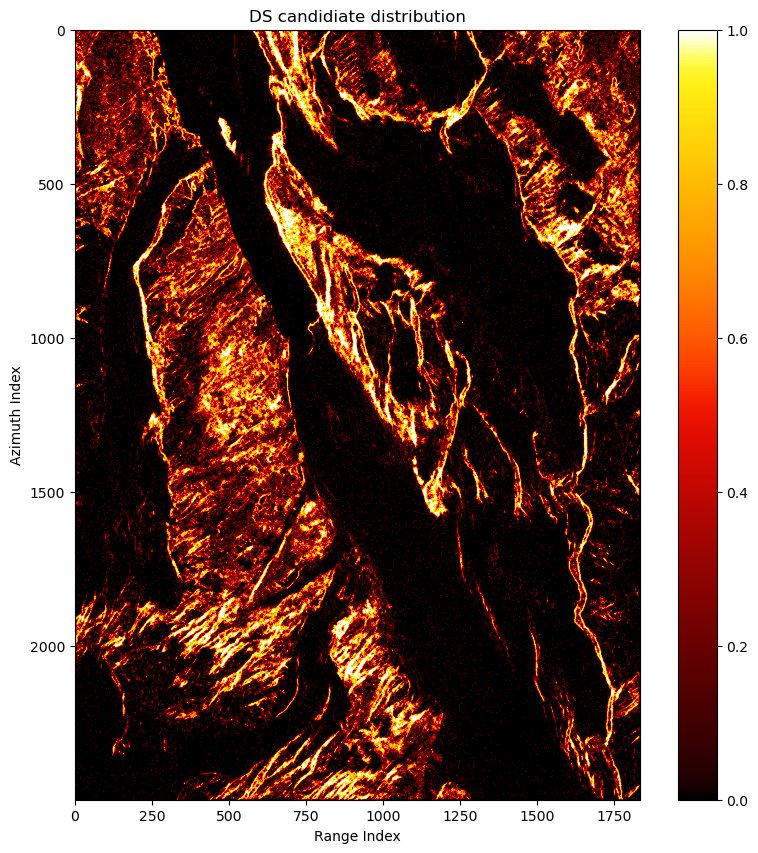

In [ ]:
is_ds_can_zarr = zarr.open(is_ds_can,'r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(is_ds_can_zarr[:],cmap=colorcet.cm.fire)
ax.set(title='DS candidiate distribution',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()